# Assignment 02: Applications of CLIP model  
📐 Assignmet description
Design experiments to validate the test performance of CLIP model in a new dataset, which is selected by students. This task is to explore the potential applications of CLIP in the real world, so students are encouraged to apply CLIP to some new scenarios (new datasets/settings/tasks/…).

📗 Recommended steps
⏳ Scenario ➟ Results ➟ Discussion ➟ Conclusion ✔️

- Select a dataset based on specific criteria, considering its size, diversity, and relevance to desired scenarios, to evaluate CLIP's performance.

- Performance Evaluation: Quantitative and qualitative results will be presented, comparing CLIP's performance to baseline models, supported by visualizations and examples.

- Discussion and Analysis: Results will be analyzed, identifying strengths, weaknesses, and potential real-world applications of CLIP in the chosen scenarios.

- Conclusion: The experiment's findings will be summarized, emphasizing the importance of validating CLIP's performance on the new dataset and providing recommendations for further investigations.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip
from torch.optim import lr_scheduler

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

### Hypermeters

In [2]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 1
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

# CLIP
VISUAL_BACKBONEs = ['RN50', 'ViT-B/32', 'ViT-B/16']

### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset: FashionMNIST

In [4]:
transform_fmnist_train = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

transform_fmnist_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.2868,), (0.3524,)),
])

train_set = torchvision.datasets.FashionMNIST(root='/shareddata', train=True,
                                       download=True, transform=transform_fmnist_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.FashionMNIST(root='/shareddata', train=False,
                                       download=True, transform=transform_fmnist_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
dataset_name = 'FashionMNIST'

### Evaluation Metric

In [5]:
model_list = ['CLIP','ResNet-101 with Zero-shot','ResNet-101 with Fine-tuning','ViT-B/32 with Zero-shot','ViT-B/32 with Fine-tuning','MLP with Simple Structure']
acc = []
top3_acc = []

## CLIP
---

- **Prompt Generation**

In [10]:
prompts = ['This is a photo of a', 'a photo of a']

def prompt_encode(prompt):
   
    text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)
    
    return text_inputs

- **Zero-shot Inference**

In [11]:
def model_inference(model, image, text_inputs):

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)
        
        logits,_ = model(image,text_inputs)

    return logits

- **Zero-shot Accuracy Calculation**

In [18]:
def clip_test(model, VISUAL_BACKBONE, prompt):
    with torch.no_grad():
        model.eval()

    ##################### Write your answer here ##################
    val_corrects = 0
    top3_corrects = 0  
    text_inputs = prompt_encode(prompt)
    
    for (image, target) in (test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model

        logits = model_inference(model, image, text_inputs)
        _, preds = torch.topk(logits, 3, dim=1)  # 取前三个最高概率的类别
        
        val_corrects += torch.sum(preds[:, 0] == target.data) 
        top3_corrects += torch.sum(preds == target.view(-1, 1).expand_as(preds))  

    val_acc = val_corrects.double() / len(test_set)
    top3_acc = top3_corrects.double() / len(test_set)
     ###############################################################

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.4f}%, visual encoder is {VISUAL_BACKBONE}, prompt is {prompt}")
    print(f"Top-3 Accuracy: {top3_acc*100:.4f}%")
    
    return val_acc, top3_acc

- **Model traning with different VISUAL_BACKBONEs and Prompts**  

In [19]:
for VISUAL_BACKBONE in VISUAL_BACKBONEs:
    for prompt in prompts:
        model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
        model.to(device)
        clip_test(model, VISUAL_BACKBONE, prompt)

the zero-shot performance on FashionMNIST is 54.0600%, visual encoder is RN50, prompt is This is a photo of a
Top-3 Accuracy: 78.1000%
the zero-shot performance on FashionMNIST is 52.4500%, visual encoder is RN50, prompt is a photo of a
Top-3 Accuracy: 74.9800%
the zero-shot performance on FashionMNIST is 65.8500%, visual encoder is ViT-B/32, prompt is This is a photo of a
Top-3 Accuracy: 88.4300%
the zero-shot performance on FashionMNIST is 63.2700%, visual encoder is ViT-B/32, prompt is a photo of a
Top-3 Accuracy: 88.0200%
the zero-shot performance on FashionMNIST is 64.7700%, visual encoder is ViT-B/16, prompt is This is a photo of a
Top-3 Accuracy: 89.3300%
the zero-shot performance on FashionMNIST is 64.8400%, visual encoder is ViT-B/16, prompt is a photo of a
Top-3 Accuracy: 89.9800%


## Baseline Model
---

### ResNet-101 with Zero-shot

- **Model**

In [18]:
resnet50 = models.resnet50(pretrained=True)

resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

resnet50 = resnet50.to(device)

In [10]:
resnet50.eval()
corrects = 0
top3_corrects = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        _, top3_preds = torch.topk(outputs, 3, dim=1)
        

        total += labels.size(0)
        corrects += (predicted == labels).sum().item()
        top3_corrects += (labels.view(-1, 1) == top3_preds).any(dim=1).sum().item()

acc =corrects / total
print(f"Accuracy on FashionMNIST: {acc * 100:.4f}%")

top3_acc = top3_corrects / total
print(f"Top-3 Accuracy on FashionMNIST: {top3_acc * 100:.4f}%")

Accuracy on FashionMNIST: 9.5600%
Top-3 Accuracy on FashionMNIST: 29.7600%


### ResNet-101 with Fine-tuning

- **Model**

In [19]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

resnet50 = resnet50.to(device)

- **Fine-tuning**

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)

#只训练最后一层
resnet50.train()

for epoch in range(NUM_EPOCHS):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

resnet50.eval()
corrects = 0
top3_corrects = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        _, top3_preds = torch.topk(outputs, 3, dim=1)
        

        total += labels.size(0)
        corrects += (predicted == labels).sum().item()
        top3_corrects += (labels.view(-1, 1) == top3_preds).any(dim=1).sum().item()

acc =corrects / total
print(f"Accuracy on FashionMNIST: {acc * 100:.4f}%")

top3_acc = top3_corrects / total
print(f"Top-3 Accuracy on FashionMNIST: {top3_acc * 100:.4f}%")

Accuracy on FashionMNIST: 79.0200%
Top-3 Accuracy on FashionMNIST: 96.0600%


### ViT-B/32 with Zero-shot

- **Model**

In [22]:
vit_model = models.vision_transformer.vit_b_32(pretrained=True)

vit_model.heads[0] = nn.Linear(vit_model.heads[0].in_features, 10)

vit_model = vit_model.to(device)

In [8]:
vit_model.eval()

corrects = 0
top3_corrects = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        _, top3_preds = torch.topk(outputs, 3, dim=1)
        

        total += labels.size(0)
        corrects += (predicted == labels).sum().item()
        top3_corrects += (labels.view(-1, 1) == top3_preds).any(dim=1).sum().item()

acc =corrects / total
print(f"Accuracy on FashionMNIST: {acc * 100:.4f}%")

top3_acc = top3_corrects / total
print(f"Top-3 Accuracy on FashionMNIST: {top3_acc * 100:.4f}%")

Accuracy on FashionMNIST: 14.0200%
Top-3 Accuracy on FashionMNIST: 38.7700%


### ViT-B/32 with Fine-tuning

- **model**

In [23]:
vit_model = models.vision_transformer.vit_b_32(pretrained=True)

for param in vit_model.parameters():
    param.requires_grad = False
    
vit_model.heads[0] = nn.Linear(vit_model.heads[0].in_features, 10)

vit_model = vit_model.to(device)

- **fine-tuning**

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vit_model.heads[0].parameters(), lr=0.001, momentum=0.9)

#只训练最后一层
vit_model.train()

for epoch in range(NUM_EPOCHS):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

vit_model.eval()

corrects = 0
top3_corrects = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        _, top3_preds = torch.topk(outputs, 3, dim=1)
        

        total += labels.size(0)
        corrects += (predicted == labels).sum().item()
        top3_corrects += (labels.view(-1, 1) == top3_preds).any(dim=1).sum().item()

acc =corrects / total
print(f"Accuracy on FashionMNIST: {acc * 100:.4f}%")

top3_acc = top3_corrects / total
print(f"Top-3 Accuracy on FashionMNIST: {top3_acc * 100:.4f}%")

Accuracy on FashionMNIST: 84.5500%
Top-3 Accuracy on FashionMNIST: 98.4000%


### MLP with Simple Structure

- **Model**

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224*224*3, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [7]:
model = MLP()
model.to(device)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=150528, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

- **train and test**

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
model.train()

for epoch in range(NUM_EPOCHS):
    model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


model.eval()

corrects = 0
top3_corrects = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        _, top3_preds = torch.topk(outputs, 3, dim=1)
        

        total += labels.size(0)
        corrects += (predicted == labels).sum().item()
        top3_corrects += (labels.view(-1, 1) == top3_preds).any(dim=1).sum().item()

acc =corrects / total
print(f"Accuracy on FashionMNIST: {acc * 100:.4f}%")

top3_acc = top3_corrects / total
print(f"Top-3 Accuracy on FashionMNIST: {top3_acc * 100:.4f}%")

Accuracy on FashionMNIST: 84.6900%
Top-3 Accuracy on FashionMNIST: 98.3400%


## Visualization
---

### CLIP with defferent VBs and prompts

In [12]:
data = {
    'Model': ['RN50 w/ this', 'RN50 w/o this', 'ViT-B/32 w/ this', 'ViT-B/32 w/o this', 'ViT-B/16 w/ this', 'ViT-B/16 w/o this'],
    'Accuracy': [54.0600, 52.4500, 65.8500, 63.2700, 64.7700, 64.8400],
    'Top-3 Accuracy': [78.1000, 74.9800, 88.4300, 88.0200, 89.3300, 89.9800]
}

df = pd.DataFrame(data)
pd.set_option('display.max_rows', None)
df

,Model,Accuracy,Top-3 Accuracy
0,RN50 w/ this,54.06,78.10
1,RN50 w/o this,52.45,74.98
2,ViT-B/32 w/ this,65.85,88.43
3,ViT-B/32 w/o this,63.27,88.02
4,ViT-B/16 w/ this,64.77,89.33
5,ViT-B/16 w/o this,64.84,89.98


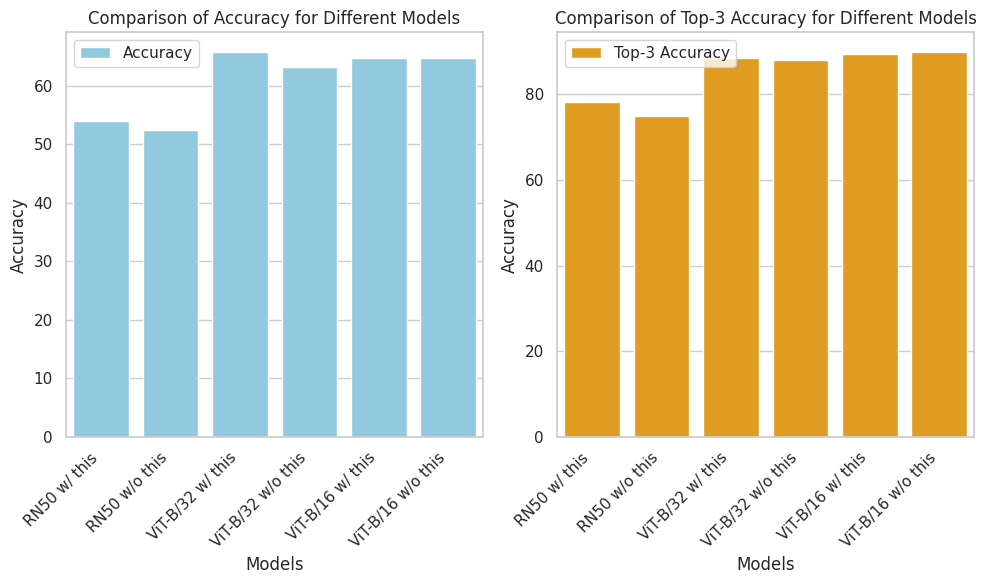

In [7]:
sns.set_theme()
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=df, color='skyblue', label='Accuracy')
#sns.barplot(x='Model', y='Top-3 Accuracy', data=df, color='orange', label='Top-3 Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy for Different Models')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.subplot(1, 2, 2)
#sns.barplot(x='Model', y='Accuracy', data=df, color='blue', label='Accuracy')
sns.barplot(x='Model', y='Top-3 Accuracy', data=df, color='orange', label='Top-3 Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Top-3 Accuracy for Different Models')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

### CLIP with Pretrained Model and MLP

In [13]:
data = {
    'Model': ['CLIP','RN101 Zero-shot', 'RN101 Fine-tuning', 'ViT-B/32 Zero-shot', 'ViT-B/32 Fine-tuning', 'MLP'],
    'Accuracy': [65.8500, 9.5600, 79.0200, 14.0200, 84.5500, 84.6900],
    'Top-3 Accuracy': [ 88.4300, 29.7600, 96.0600, 38.7700, 98.4000,98.3400]
}

df = pd.DataFrame(data)
pd.set_option('display.max_rows', None)
df

,Model,Accuracy,Top-3 Accuracy
0,CLIP,65.85,88.43
1,RN101 Zero-shot,9.56,29.76
2,RN101 Fine-tuning,79.02,96.06
3,ViT-B/32 Zero-shot,14.02,38.77
4,ViT-B/32 Fine-tuning,84.55,98.40
5,MLP,84.69,98.34


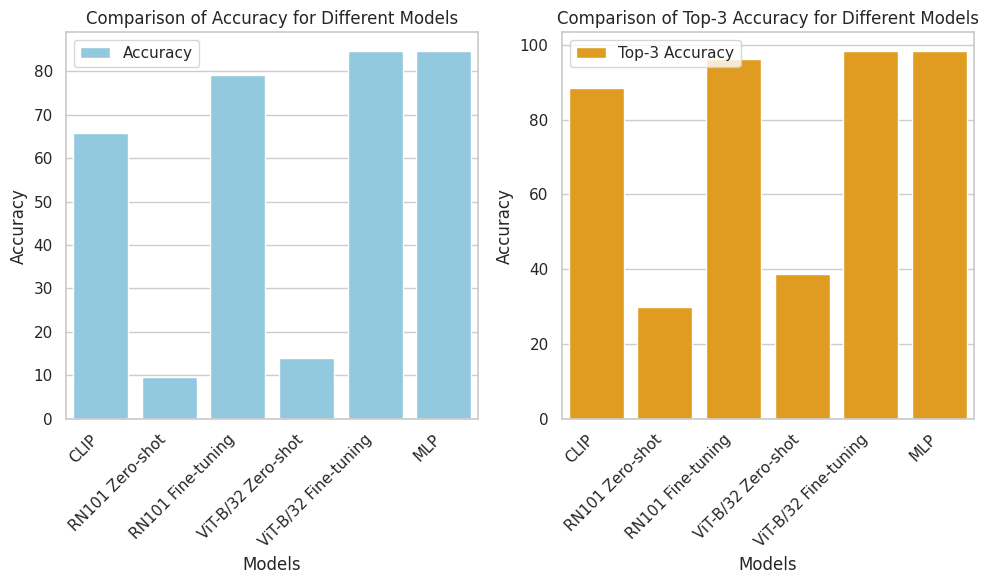

In [33]:
sns.set_theme()
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=df, color='skyblue', label='Accuracy')
#sns.barplot(x='Model', y='Top-3 Accuracy', data=df, color='orange', label='Top-3 Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy for Different Models')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.subplot(1, 2, 2)
#sns.barplot(x='Model', y='Accuracy', data=df, color='blue', label='Accuracy')
sns.barplot(x='Model', y='Top-3 Accuracy', data=df, color='orange', label='Top-3 Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Top-3 Accuracy for Different Models')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()